In [ ]:
#--------------------------- Importar librerias -------------------------------#

import pandas as pd # Cargar datos CSV
import numpy as np # Arrays
from sklearn.model_selection import train_test_split # División datos
import torch # PyTorch - Redes neuronales
import torch.nn as nn # Definir y entrenar redes neuronales
from torch import optim # Algoritmos de optimización
import torch.nn.functional as F # Funciones de activación
from torch.optim.lr_scheduler import StepLR # tasa de aprendizaje
import seaborn as sns # Matriz de confusión
import matplotlib.pyplot as plt # Gráficas
# Métricas de evaluación
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve

#-------------------- Cargar los datos desde archivos CSV ---------------------#

# Cargar los datos de entrenamiento
X_train = pd.read_csv('/content/EstrogenReceptorStatus_Train.csv',index_col=0)
# Cargar las etiquetas de los datos de entrenamiento
y_train = pd.read_csv('/content/EstrogenReceptorStatus_Train_labels.txt',header=None)

# Cargar los datos de evaluación
X_test = pd.read_csv('/content/EstrogenReceptorStatus_Test.csv',index_col=0)
# Cargar las etiquetas de los datos de evaluación
y_test = pd.read_csv('/content/EstrogenReceptorStatus_Test_labels.txt',header=None)


In [ ]:
#-------------------------- Exploración de los datos --------------------------#

# Dimensión de los datos de entrenamiento
print("Training shape: {}".format(X_train.shape))
# Head de los primeros 3 datos de entrenamiento
print("Training data head")
print(X_train.head(3))

# Dimensiones de las etiquetas de los datos de entrenamiento
print("Training labels shape: {}".format(y_train.shape))
# Head de las primeras 3 etiquetas correspondientes
print("Training labels head")
print(y_train.head(3))
# Número de ejemplos por clase usando el método groupby en las etiquetas de los datos de entrenamiento
print("Examples per label")
print(y_train.groupby([0])[0].count())

# Dimensión de los datos de evaluación
print("Test shape: {}".format(X_test.shape))
# Head de los primeros 3 datos de evaluación
print("Test data head")
print(X_test.head(3))

# Dimensiones de las etiquetas de los datos de evaluación
print("Test labels shape: {}".format(y_test.shape))
# Head de las primeras 3 etiquetas correspondientes
print("Test labels head")
print(y_test.head(3))
# Número de ejemplos por clase usando el método groupby en las etiquetas de los datos de evaluación
print("Examples per label")
print(y_test.groupby([0])[0].count())


Training shape: (216, 162)
Training data head
         1-hexadecanol  1-monostearin  1,2,4-benzenetriol  \
case_95       9.729131       9.372530           12.635429   
case_88      10.961073       9.353313           12.692373   
case_24      10.995057       9.384110           12.954097   

         1,5-anhydroglucitol  2-aminoadipic,acid  2-hydroxybutanoic,acid  \
case_95            14.711658           11.162607               14.145654   
case_88            14.371407           11.128662               14.228230   
case_24            13.323175            8.162313               14.392132   

         2-hydroxyglutaric,acid  2-hydroxyvaleric,acid  2-ketoadipic,acid  \
case_95               12.334462              14.358346          12.103635   
case_88               12.177452              14.923601          12.378531   
case_24               17.532062              16.000497          12.558596   

         2-ketoglucose,dimethylacetal,NIST  ...  trehalose  tryptophan  \
case_95              

In [ ]:
#------------------- Convertir los datos a arreglos de numpy ------------------#

# X_train = X_train.to_numpy
X_train = np.asarray(X_train)
# y_train = y_train.to_numpy
y_train = np.asarray(y_train)

# X_test = X_test.to_numpy
X_test = np.asarray(X_test)
# y_test = y_test.to_numpy
y_test = np.asarray(y_test)

#------------------- Mapear los datos a tensores de PyTorch -------------------#

# Convertir los datos de entrenamiento y prueba en tensores
X_train, y_train, X_test, y_test = map(torch.tensor, (X_train, y_train, X_test, y_test))

# Aplanar los tensores - tensores unidimensionales
y_train = torch.flatten(y_train)
y_test = torch.flatten(y_test)

# Dimensiones de los datos
print("Training data shape: {}".format(X_train.shape)) # Train
print("Training label shape: {}".format(y_train.shape)) # Train labels
print("Test data shape: {}".format(X_test.shape)) # Test
print("Test label shape: {}".format(y_test.shape)) # Test label

#---------------- Cambiar el tipo de datos de los tensores --------------------#

X_train = X_train.float() # Train - Punto flotante
y_train = y_train.long() # Train labels - entero largo
X_test = X_test.float() # Test - Punto flotante
y_test = y_test.long() # Test labels - entero largo

# Dimensiones de los datos
print("Training data shape: {}".format(X_train.shape)) # Train
print("Training label shape: {}".format(y_train.shape)) # Train labels
print("Test data shape: {}".format(X_test.shape)) # Test
print("Training data shape: {}".format(y_test.shape)) # Test labels


Training data shape: torch.Size([216, 162])
Training label shape: torch.Size([216])
Test data shape: torch.Size([55, 162])
Test label shape: torch.Size([55])
Training data shape: torch.Size([216, 162])
Training label shape: torch.Size([216])
Test data shape: torch.Size([55, 162])
Training data shape: torch.Size([55])


In [ ]:
#--------------- Definición de la red neuronal feedforward --------------------#

# Se define una red neuronal feedforward con tres capas ocultas
# y una capa de salida Softmax para la clasificación de datos

class FFNN(nn.Module):

    #  Inicialización del Modelo #
    def __init__(self):
        super().__init__() # Constructor
        torch.manual_seed(0) # Reproducibilidad

        # Definición de la arquitectura del modelo como una secuencia de capas #
        self.net = nn.Sequential(
            nn.Linear(162, 30), # Primera capa lineal - 162 entradas (características) y 30 salidas
            nn.ReLU(), # Función de activación ReLU - valores negativos a cero y valores positivos sin cambios
            nn.Linear(30, 30), # Segunda capa, transformación lineal - 30 entradas y 30 salidas
            nn.ReLU(), # Función de activación ReLU - valores negativos a cero y valores positivos sin cambios
            nn.Linear(30, 2), # Capa de salida -  30 entradas y 2 salidas que corresponden a las clases (1 o 0)
            nn.Softmax() # Función de activación Softmax - distribución de probabilidad de cada clase
            #nn.Sigmoid()
        )

    # Método Forward - define el paso hacia adelante de la red
    # Pasa el tensor dado X a través de las capas definidas anteriormente en self.net
    def forward(self, X):
        return self.net(X)

    # Método de Predicción
    # Dado un tensor de entrada X, calcula las predicciones de la red neuronal y las devuelve
    def predict(self, X):
        Y_pred = self.forward(X)
        return Y_pred


In [ ]:
#------------------- Definición del Bucle de Entrenamiento --------------------#

'''
Se crea una función llamada fit que toma como entrada:

- x (los datos de entrada)
- y (las etiquetas correspondientes)
- model (la arquitectura del modelo)
- opt (el optimizador)
- loss_fn (la función de pérdida)
- epochs (el número de épocas de entrenamiento, por defecto 1000)

Después de completar todas las épocas, la función devuelve el valor de la pérdida final
(última época) y una lista con las pérdidas en cada época.
'''

# Establecer la semilla para funciones aleatorias de PyTorch
torch.manual_seed(42)

def fit(x, y, model, opt, loss_fn, epochs = 1000):

    losses = []  # Lista para almacenar las pérdidas en cada época

    # Bucle de entrenamiento - Iteración sobre el número de épocas
    for epoch in range(epochs):

        loss = loss_fn(model(x), y) # Calculo de la Pérdida
        loss.backward() # Backpropagation
        opt.step() # Optimización
        opt.zero_grad() # Reiniciar los gradientes de las variables a 0 (evitar acumulación de gradientes)
        # print(loss.item())

        losses.append(loss.item())  # Almacena la pérdida actual

    return loss.item(), losses # Retorno de la Pérdida Final y la lista con todas las pérdidas


In [ ]:
#--------------------- Establecimiento del Dispositivo ------------------------#

# Establecimiento de CPU como dispositivo
device = torch.device("cpu")

# Transferencia de Datos y Modelo al Dispositivo CPU
X_train=X_train.to(device)
y_train=y_train.to(device)
X_test=X_test.to(device)
y_test=y_test.to(device)

# Creación del Modelo y Transferencia al Dispositivo CPU
fn = FFNN()
fn.to(device)

FFNN(
  (net): Sequential(
    (0): Linear(in_features=162, out_features=30, bias=True)
    (1): ReLU()
    (2): Linear(in_features=30, out_features=30, bias=True)
    (3): ReLU()
    (4): Linear(in_features=30, out_features=2, bias=True)
    (5): Softmax(dim=None)
  )
)

In [ ]:
#------------ Definición de la Función de Pérdida y el Optimizador ------------#

# Función de pérdida utilizando la entropía cruzada, para problemas de clasificación
loss_fn = F.cross_entropy

# Crear el ptimizador utilizando el algoritmo de descenso de gradiente estocástico (SGD)
# con una tasa de aprendizaje de 0.01
opt = optim.SGD(fn.parameters(), lr=0.01)


In [ ]:
#------------------------ Entrenamiento del modelo ----------------------------#

# Se realiza el entrenamiento aplicando la función fit
# Y se imprime a pantalla la pérdida final

t1_final_loss, t1_losses = fit(X_train, y_train, fn, opt, loss_fn)
print('Final loss', t1_final_loss)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Final loss 0.5676087141036987


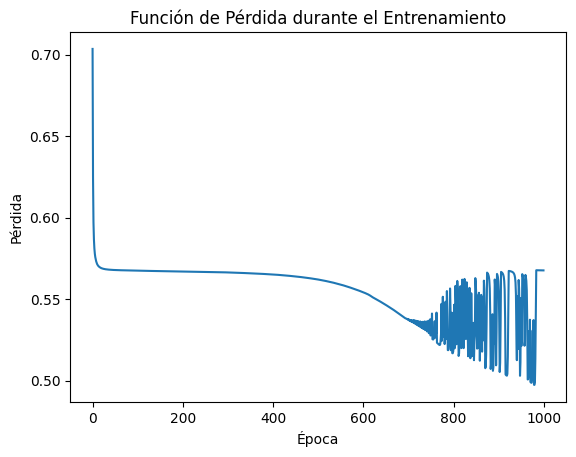

In [ ]:
#----------------------------- Función de Pérdida ------------------------------#

### Entrenamiento 1 ###

plt.plot(t1_losses)
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.title('Función de Pérdida durante el Entrenamiento')
plt.show()

In [ ]:
# --------------- Épocas con menor y mayor valor de pérdida -------------------#

print(f'El valor mínimo de pérdida fue {min(t1_losses)} en la época {t1_losses.index(min(t1_losses))}')
print(f'El valor máximo de pérdida fue {max(t1_losses)} en la época {t1_losses.index(max(t1_losses))}')

El valor mínimo de pérdida fue 0.4973188638687134 en la época 979
El valor máximo de pérdida fue 0.7035389542579651 en la época 0


In [ ]:
#--------------------- Función para métricas de evaluación --------------------#

def evaluate_model(model, X, y_true):

    # Obtener las predicciones del modelo
    y_pred = model.predict(X)

    # Calcular la precisión
    accuracy = accuracy_score(y_true, torch.argmax(y_pred, dim=1).cpu().numpy())
    print("Accuracy: {:.4f}".format(accuracy))

    # Calcular la matriz de confusión
    cm = confusion_matrix(y_true, torch.argmax(y_pred, dim=1).cpu().numpy())
    print("Confusion Matrix:\n", cm)

    # Visualizar la matriz de confusión como una imagen con seaborn
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # Calcular y mostrar la curva ROC y el área bajo la curva (AUC)
    y_scores = model(X).detach().cpu().numpy()[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    auc = roc_auc_score(y_true, y_scores)
    print("AUC: {:.4f}".format(auc))

    # Graficar la curva ROC
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

Evaluation on Training Set:
Accuracy: 0.7454
Confusion Matrix:
 [[  0  55]
 [  0 161]]


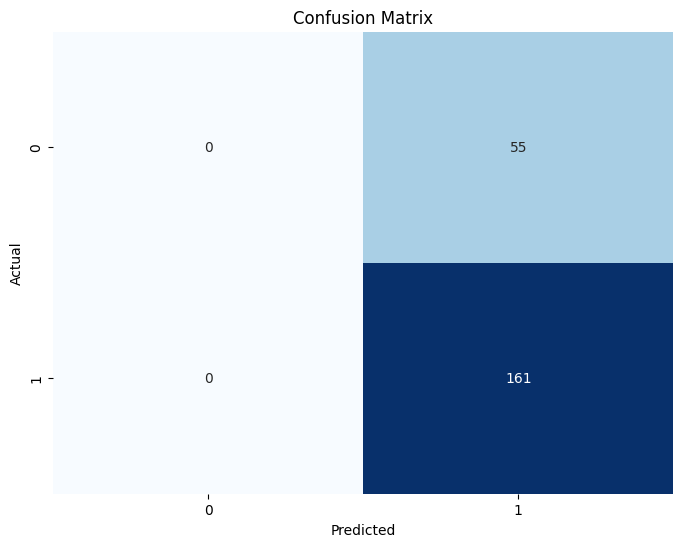

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


AUC: 0.8830


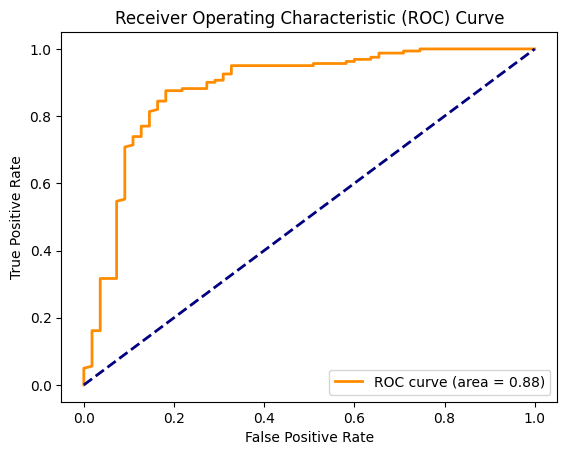

In [ ]:
#------------------ Evaluar en el conjunto de entrenamiento -------------------#

print("Evaluation on Training Set:")
evaluate_model(fn, X_train, y_train)



Evaluation on Test Set:
Accuracy: 0.7818
Confusion Matrix:
 [[ 0 12]
 [ 0 43]]


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


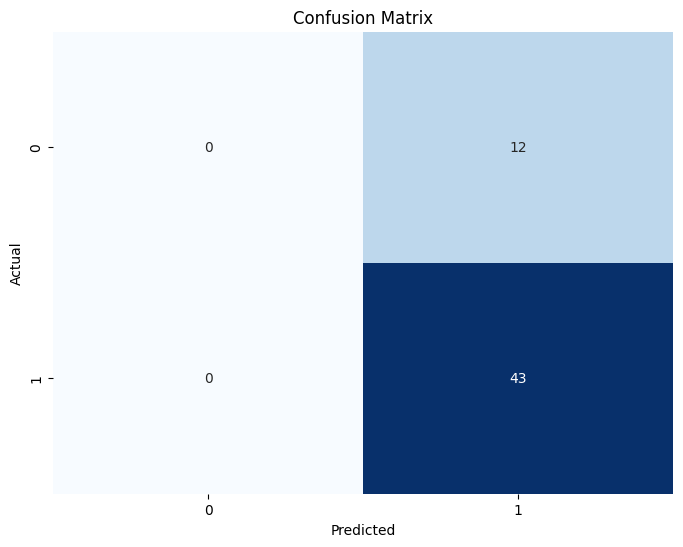

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


AUC: 0.7326


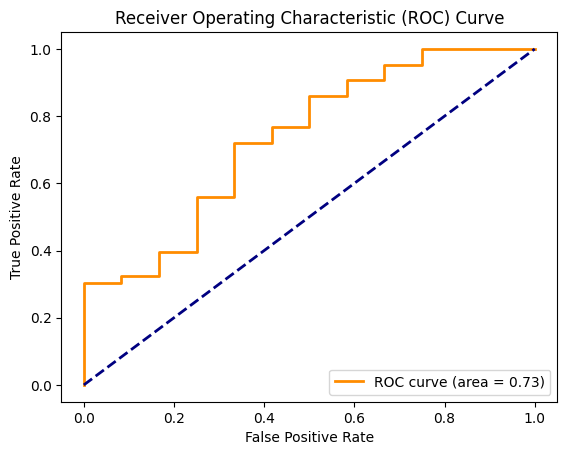

In [ ]:
#--------------------- Evaluar en el conjunto de prueba -----------------------#

print("\nEvaluation on Test Set:")
evaluate_model(fn, X_test, y_test)
